In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from IPython.display import display
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as pl
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import xgboost as xgb
from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
# Pretty display for notebooks
%matplotlib inline

# Any results you write to the current directory are saved as output.

C:\Users\andre\Anaconda2\envs\python3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
data = pd.read_csv("../input/train.csv", parse_dates=['timestamp'])
prices = data['price_doc']
train_data = data.drop(['price_doc','id'], axis =1)

In [2]:
data = pd.read_csv("train.csv", parse_dates=['timestamp'])
prices = data['price_doc']
train_data = data.drop(['price_doc','id'], axis =1)

In [ ]:
data.select_dtypes(include=[object]).head()

In [ ]:
macros = pd.read_csv("macro.csv",parse_dates=['timestamp'])

In [ ]:
columns_convert = macros.select_dtypes(include=[object]).keys()
macros[columns_convert]= macros[columns_convert].apply(lambda x: pd.to_numeric(x.astype(str)
                                                                               .str.replace(',','.'), errors='ignore'))
macros[columns_convert].info()

In [3]:
def col_convert(df):
    columns_convert = df.select_dtypes(include=[object]).keys()
    df[columns_convert]= df[columns_convert].apply(lambda x: pd.to_numeric(x.astype(str)
                                                                          .str.replace(',','.'), errors='ignore'))
    df[columns_convert].head()
    return df

In [ ]:
macro_prices = data['timestamp','price_doc']
print(macro_prices.head())
macro_raw = pd.merge_ordered(macros,macro_prices, on='timestamp', how='inner')
macro_raw.drop('timestamp',axis=1,inplace =True)

In [4]:
#print(features_raw[features_raw.child_on_acc_pre_school.notnull()].head(1))
#print(features_raw.info())
def replace_mfloor(x,floor):
    if (np.isnan(x)) or( x == 0):
        return floor
    elif floor > x:
        return   floor
    else:
        return x
def replace_buildy(x):
    if (np.isnan(x)) or( x == 0):
        return -1
    elif x == 20052009:
        return 2005
    elif x == 4965:
        return 1965
    elif x <= 20:
        return 2000 + x
    elif x < 100:
        return 1900 + x
    elif x < 220:
        return 1800 + x
    else:
        return x
def replace_sq(x,full,avg):
    if (np.isnan(x)) or( x == 0):
        return -1
    else:
        return x
def fix_state(x):
    if x ==33:
        return 3
    else:
        return x

In [5]:
index_drop = train_data.loc[(train_data['full_sq']== 0)]
display(index_drop)
features_raw = train_data.drop([17932,24296],axis=0)
prices.drop([17932,24296],axis=0, inplace=True)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
17932,2014-04-28,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,8,0,0,0,1,7,1,0,12,1
24296,2014-11-05,0,77.0,4.0,17.0,1.0,0.0,3.0,0.0,1.0,...,5,1,1,0,2,12,0,1,10,0


In [6]:
full_sq_avg = np.nanmean(features_raw['full_sq'])
life_sq_avg =  np.nanmean(features_raw['life_sq'])
kitch_sq_avg = np.nanmean(features_raw['kitch_sq'])
life_ratio = life_sq_avg / full_sq_avg
kitch_ratio = kitch_sq_avg / full_sq_avg
print (life_ratio,kitch_ratio)

0.634531711434 0.118040764532


In [8]:
features_raw[['floor']] = features_raw[['floor']].fillna(value=-1)
features_raw['max_floor']= features_raw.apply(lambda row: replace_mfloor(row['max_floor'],row['floor']), axis=1)
features_raw['build_year'] = features_raw.apply(lambda row: replace_buildy(row['build_year']), axis=1)
features_raw['life_sq']= features_raw.apply(lambda row: replace_sq(row['life_sq'],row['full_sq'],life_ratio), axis=1)
features_raw['kitch_sq']= features_raw.apply(lambda row: replace_sq(row['kitch_sq'],row['full_sq'],kitch_ratio), axis=1)
features_raw['flor_prop'] = features_raw['floor'] / features_raw['max_floor']
features_raw['state'] = features_raw.apply(lambda row: fix_state(row['state']), axis=1)

In [10]:
display(features_raw['material'].unique() )
display(features_raw['state'].unique() )
features_raw.drop('timestamp',axis=1,inplace =True)

array([ nan,   1.,   2.,   4.,   6.,   5.,   3.])

array([ nan,   3.,   1.,   2.,   4.])

In [11]:
#encode the 'features' data with label encored
from sklearn.preprocessing import LabelEncoder
objects = features_raw.select_dtypes(include=['object']).keys()
from collections import defaultdict
d = defaultdict(LabelEncoder)
# Encoding the variable
features = col_convert(features_raw)
#display (features[objects].head(1))
features[objects] = features_raw[objects].apply(lambda x: d[x.name].fit_transform(x))
'''
for col in objects:
        print ('column')
        lbl.fit(list(features_raw[col].values)) 
        features_raw[col] = lbl.transform(list(features_raw[col].values))

features = features_raw
'''
# remove boolean with _no
#features = features.drop(features.filter(regex='_no', axis=1),axis=1)
features = features.drop(features.filter(regex='_all', axis=1),axis=1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print ("{} total features after encoding.".format(len(encoded)))


array([0, 1], dtype=int64)

281 total features after encoding.


In [15]:
# Uncomment the following line to see the encoded feature names
#features.fillna(-1, inplace = True)
display (features[objects].isnull().sum())
#display(features['material'].unique() )
#display(features['state'].unique() )

product_type                 0
sub_area                     0
culture_objects_top_25       0
thermal_power_plant_raion    0
incineration_raion           0
oil_chemistry_raion          0
radiation_raion              0
railroad_terminal_raion      0
big_market_raion             0
nuclear_reactor_raion        0
detention_facility_raion     0
water_1line                  0
big_road1_1line              0
railroad_1line               0
ecology                      0
dtype: int64

In [16]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler((-1,10))
numerical = list(features_raw.select_dtypes(include=['float64','int64']).keys())
numerical.remove('material')
numerical.remove('state')


features.fillna(-1, inplace = True)

#print(features_raw[numerical].isnull().sum())
#features_raw[numerical] = scaler.fit_transform(features_raw[numerical])
features = scaler.fit_transform(features)
# Show an example of a record with scaling applied

#display(features_raw['state'].unique() )

In [17]:
from sklearn.feature_selection import SelectKBest,f_regression
kbest = SelectKBest(score_func=f_regression,k=250)
best_features = kbest.fit_transform(features,prices)

In [21]:
#best_features.replace(-1,np.NaN, inplace = True)
best_features[best_features== -1]= np.nan

In [24]:
print(best_features)

keep_features = np.sort(kbest.pvalues_)[::-1]

keep_features =keep_features[np.where(keep_features > 0 )]
print (len(keep_features))

[[-0.91323944 -0.95881802 -0.29487179 ...,         nan  1.62385321
   1.0952381 ]
 [-0.93183099 -0.9705843  -0.43589744 ...,  0.03773585  2.33027523
   6.33333333]
 [-0.91323944 -0.95587645 -0.57692308 ..., -0.58490566  2.38073394
   4.23809524]
 ..., 
 [-0.90910798         nan  0.55128205 ..., -0.89622642 -0.44495413
  -0.47619048]
 [-0.86985915 -0.9514641  -0.15384615 ..., -0.58490566  2.27981651
   2.66666667]
 [-0.91323944 -0.95734724 -0.71794872 ..., -0.06603774  1.72477064
   4.23809524]]
250


In [ ]:
#Minimum price of the data
minimum_price = np.min(prices)

#Maximum price of the data
maximum_price = np.max(prices)

#Mean price of the data
mean_price = np.mean(prices)

#Median price of the data
median_price = np.median(prices)

#Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print ("Statistics for russian housing dataset:\n")
print ("Minimum price: Rub {:,.2f}".format(minimum_price))
print ("Maximum price: Rub {:,.2f}".format(maximum_price))
print ("Mean price: Rub {:,.2f}".format(mean_price))
print ("Median price Rub {:,.2f}".format(median_price))
print ("Standard deviation of prices: Rub {:,.2f}".format(std_price))
#added statistic for critica alfa = 0.05 double tailed cutover
#calculating standard error using correction for sample size n = 100
alfa_c = (std_price/99)*1.96
print ("critical alfa score for sample size of 100: Rub {:,.2f}".format(alfa_c))

In [ ]:
from sklearn.metrics import mean_squared_error
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    score = mean_squared_error(y_true, y_predict) 
    return score

In [ ]:
from sklearn.model_selection import train_test_split
#Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features,prices, test_size =0.2, random_state = 33)
print ("Training and testing split was successful.")

In [ ]:
# Produce learning curves for varying training set sizes and maximum depths
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.model_selection import learning_curve as curves

from sklearn.tree import DecisionTreeRegressor
def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):
        
        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = curves(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')
        
        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve 
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')
        
        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])
    
    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()

In [ ]:
ModelLearning(features, prices)

In [ ]:
from sklearn.model_selection import validation_curve
def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('Score')
    pl.ylim([-0.05,1.05])
    pl.show()

In [ ]:
ModelComplexity(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, NMF
pca = NMF(random_state=33).fit(features)

In [ ]:
#pca explanation
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions
   

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    #fig, ax = pl.subplots(figsize = (6,6))

    # Plot the feature weights as a function of the components
    #components.plot(ax = ax, kind = 'bar')
    #pl.hist(components)
    #ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(dimensions, rotation=1)


    # Display the explained variance ratios
    #for i, ev in enumerate(pca.explained_variance_ratio_):
    #    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_result = pca_results(features,pca)
#pca_results(X_train,pca)

In [ ]:
pca_result['Explained Variance'].cumsum()

In [ ]:
# Fit the training data to the model using grid search
pca = PCA(n_components = 149, random_state =33 )
X_trainPCA = pca.fit_transform(features)
#X_testPCA = pca.transform(X_test)
#reg = reg.fit(X_trainPCA, y_train)
#y_val = reg.predict(X_testPCA)
#print (performance_metric(y_test,y_val))

In [26]:
#optimising model
#eta 0.05 = 2.62690e+06
#eta 0.015 = 2.59523e+06
#eta 0.015 = 2.63821e+06
#2.6557+06
xgb_params = {
    'eta': 0.018,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(best_features, prices)
#dtrain = xgb.DMatrix(features, prices)

[0]	train-rmse:8.44398e+06	test-rmse:8.44566e+06
[50]	train-rmse:4.29803e+06	test-rmse:4.41774e+06
[100]	train-rmse:2.8976e+06	test-rmse:3.17998e+06
[150]	train-rmse:2.45765e+06	test-rmse:2.86561e+06
[200]	train-rmse:2.29101e+06	test-rmse:2.77604e+06
[250]	train-rmse:2.20449e+06	test-rmse:2.73989e+06
[300]	train-rmse:2.14829e+06	test-rmse:2.7199e+06
[350]	train-rmse:2.10158e+06	test-rmse:2.70482e+06
[400]	train-rmse:2.06454e+06	test-rmse:2.69449e+06
[450]	train-rmse:2.02997e+06	test-rmse:2.68534e+06
[500]	train-rmse:2.00018e+06	test-rmse:2.67921e+06
[550]	train-rmse:1.97285e+06	test-rmse:2.67334e+06
[600]	train-rmse:1.9456e+06	test-rmse:2.66845e+06
[650]	train-rmse:1.92062e+06	test-rmse:2.66449e+06
[700]	train-rmse:1.89607e+06	test-rmse:2.66042e+06
[750]	train-rmse:1.87395e+06	test-rmse:2.65746e+06
[800]	train-rmse:1.8541e+06	test-rmse:2.65548e+06
[850]	train-rmse:1.83493e+06	test-rmse:2.65333e+06
[900]	train-rmse:1.81561e+06	test-rmse:2.65104e+06
[950]	train-rmse:1.79738e+06	test-rmse

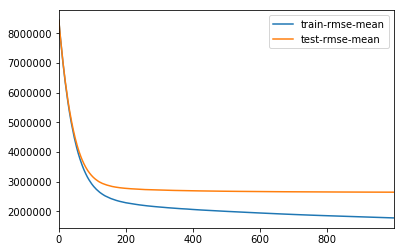

In [27]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [ ]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

In [ ]:
fig, ax = pl.subplots(1, 1, figsize=(12, 13))
xgb.plot_importance(model, ax =ax)

In [ ]:
#prepare test data:
test_data = pd.read_csv("test.csv", parse_dates=['timestamp'])
id_test = test_data.id
test_features_raw = test_data.drop(['id'], axis =1)

#test_features_raw = pd.merge_ordered(test_data, macros, on='timestamp', how='left')
test_features_raw.drop('timestamp',axis=1,inplace =True)

test_features_raw[['floor']] = test_features_raw[['floor']].fillna(value=0)
test_features_raw['max_floor']= test_features_raw.apply(lambda row: replace_mfloor(row['max_floor'],row['floor']), axis=1)
test_features_raw['build_year'] = test_features_raw.apply(lambda row: replace_buildy(row['build_year']), axis=1)
test_features_raw['life_sq']= test_features_raw.apply(lambda row: replace_sq(row['life_sq'],row['full_sq'],life_ratio), axis=1)
test_features_raw['kitch_sq']= test_features_raw.apply(lambda row: replace_sq(row['kitch_sq'],row['full_sq'],kitch_ratio), axis=1)

test_features_raw['state'] = test_features_raw.apply(lambda row: fix_state(row['state']), axis=1)

test_features_raw['flor_prop'] = test_features_raw['floor'] / test_features_raw['max_floor']

test_features_raw[numerical].fillna(-1, inplace = True)

#test_features_raw[numerical] = scaler.transform(test_features_raw[numerical])
test_features = test_features_raw
# Using the dictionary to label future data
test_features['product_type'].fillna('OwnerOccupier', inplace =True)
#display(test_features_raw['product_type'].unique())
test_features[objects] = test_features[objects].apply(lambda x: d[x.name].transform(x))
test_features.fillna(-1, inplace = True)

# remove boolean with _no
#test_features = test_features.drop(test_features.filter(regex='_no', axis=1),axis=1)
test_features = test_features.drop(test_features.filter(regex='_all', axis=1),axis=1)
testdataPCA = kbest.transform(test_features)


In [ ]:
display(test_features_raw.product_type.unique())

In [ ]:
test_features.head(1)

In [ ]:
dtest = xgb.DMatrix(testdataPCA)
y_pred = model.predict(dtest,ntree_limit=model.best_ntree_limit)

df_submit = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_submit.to_csv('submit.csv', index=False)